In [1]:
# rmbranto 2021/08
# analytical graph and map functions:
# - stacked bar graph ...
# - occ line plot ...
# - area line plot
# - graph OCCS AREA and YEAR
# - prov bar plot
# - occs and areas over time               
# - map by species with option for pacific centric view ... 


options(stringsAsFactors = FALSE)
library(stringr)
library(magrittr)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
fName<-'invasives.rda'
load(file=paste('short-',fName,sep=''))
objects()

[1] "df"            "df.exp"        "df.prov"       "eez.shp"      
 [5] "fao.shp"       "fn"            "fName"         "prov.keys"    
 [9] "prov.style"    "species.style"

In [3]:
# summary of input data ...

tapply(df.prov$OCCS,list(species=df.prov$species,prov=df.prov$prov),sum,na.rm=TRUE)%>%
rbind(.,total=apply(.,2,sum,na.rm=TRUE))%>%
cbind(.,total=apply(.,1,sum,na.rm=TRUE))%>%
.[,c(1:3,5:8,9,4,10)]

# prepare expanded data
df<-df.prov%>%
    transform(area=str_pad(paste(round(latitude,1),round(longitude,1)),13,'right','.'))%>%
    group_by(species, prov ,year, eez, fao ,area) %>%
    summarize(OCCS = sum(OCCS, na.rm = TRUE))%>%
    transform(data=paste(species,prov,year,eez,fao,area,sep=';'))%>%
    .[,c('data','OCCS')]

fn=tempfile("df.exp")               
write(unlist(rep(df$data,df$OCCS)),fn)
df.exp<-data.frame(read.csv(fn,header=FALSE,sep=';'))
names(df.exp)<-c('species','prov','year','eez','fao','area')

# summary of expanded data ...
names(df.exp)
nrow(df.exp)

table(df.exp$species,df.exp$prov)%>%
rbind(.,total=apply(.,2,sum,na.rm=TRUE))%>%
cbind(.,total=apply(.,1,sum,na.rm=TRUE))%>%
.[,c(1:3,5:8,9,4,10)]

,ala,bison,bold,gbif,idigbio,inat,obis,UNIQUE,DUPS,total
Carcinus maenas,236,1652,10,9988,127,6785,8408,26794,412,54412
Caulerpa taxifolia,501,248,NA,1355,403,55,637,2432,767,6398
Codium fragile,454,1268,NA,6006,895,2341,759,10345,1378,23446
Dreissena polymorpha,NA,4717,20,9979,514,1284,769,15185,2098,34566
Mnemiopsis leidyi,NA,87,NA,1166,12,262,2314,3479,362,7682
Pterois volitans,515,1213,NA,9999,282,1523,2602,15175,959,32268
Rapana venosa,NA,NA,1,272,10,191,178,627,25,1304
total,1706,9185,31,38765,2243,12441,15667,74037,6001,160076


`summarise()` has grouped output by 'species', 'prov', 'year', 'eez', 'fao'. You can override using the `.groups` argument.


[1] "species" "prov"    "year"    "eez"     "fao"     "area"

[1] 160076

,ala,bison,bold,gbif,idigbio,inat,obis,UNIQUE,DUPS,total
Carcinus maenas,236,1652,10,9988,127,6785,8408,26794,412,54412
Caulerpa taxifolia,501,248,0,1355,403,55,637,2432,767,6398
Codium fragile,454,1268,0,6006,895,2341,759,10345,1378,23446
Dreissena polymorpha,0,4717,20,9979,514,1284,769,15185,2098,34566
Mnemiopsis leidyi,0,87,0,1166,12,262,2314,3479,362,7682
Pterois volitans,515,1213,0,9999,282,1523,2602,15175,959,32268
Rapana venosa,0,0,1,272,10,191,178,627,25,1304
total,1706,9185,31,38765,2243,12441,15667,74037,6001,160076


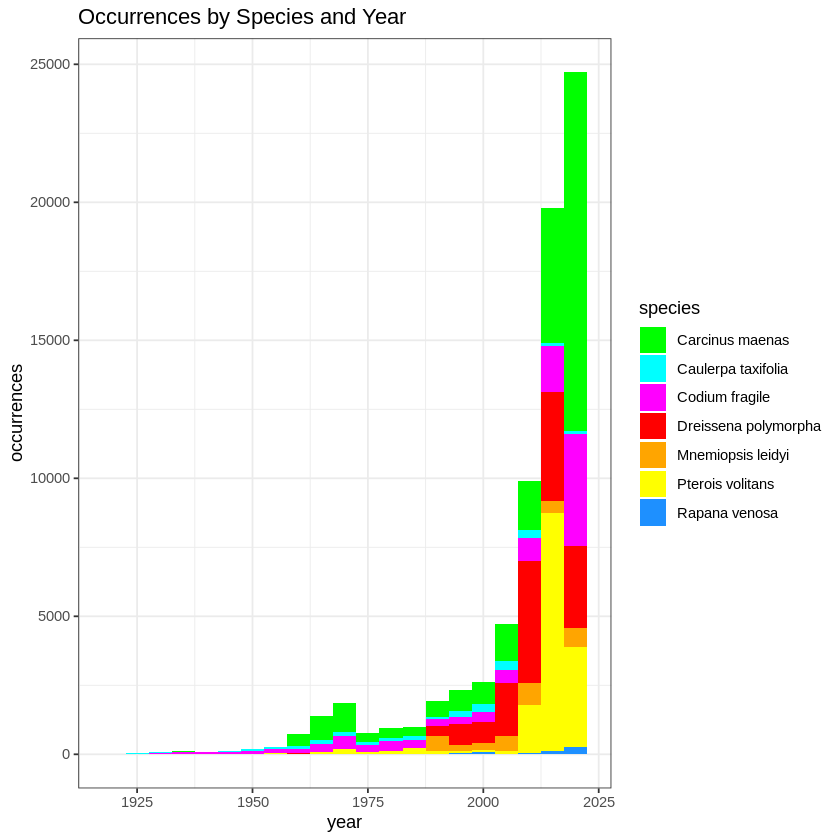

In [4]:
# stacked bar graph ...
my.binwidth<-5
ggplot(df.exp[df.exp$prov=='UNIQUE'&df.exp$year>=1921,]) + 
geom_histogram(aes(x=year,fill=species),binwidth=my.binwidth)+
scale_fill_manual(name = 'species', values=species.style$sColors, labels=species.style$Names)+
labs(title='Occurrences by Species and Year')+ylab('occurrences')+theme_bw()

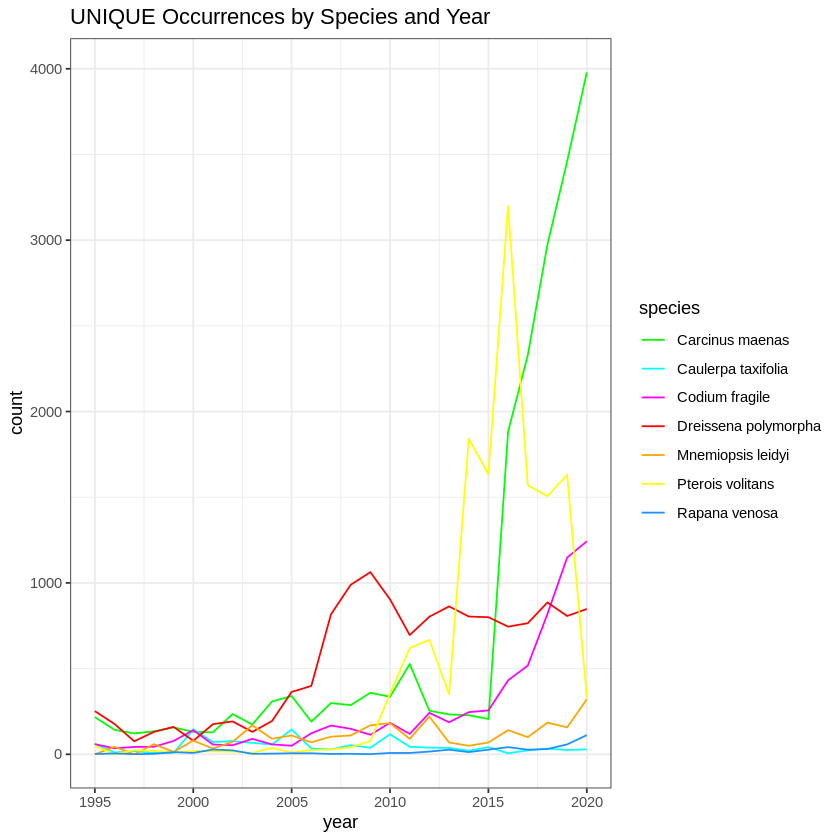

In [5]:
# occ line plot ...

do.occ.line<-function(my.species='',my.prov='UNIQUE',
        my.sYear=min(df.exp$year),my.eYear=max(df.exp$year)){

my.species=species.style%>%.[,'Names']%>%grep(my.species,.)%>%species.style[.,'Names']    
my.prov=prov.style%>%.[,'prov']%>%grep(my.prov,.)%>%prov.style[.,'prov']    

df.exp<-df.exp[df.exp$species%in%my.species & df.exp$prov==my.prov,]
species.style<-species.style[species.style$Names%in%unique(df.exp$species),]
    
my.binwidth<-1
suppressWarnings(print(
p<-ggplot(df.exp) + 
geom_freqpoly(aes(x=year,color=species),binwidth=my.binwidth)+
scale_color_manual(name = 'species', values=species.style$sColors, labels=species.style$Names)+
labs(title=paste(my.prov,'Occurrences by Species and Year'))+theme_bw()+xlim(my.sYear,my.eYear)
))
}

my.binwidth<-1
do.occ.line(,'UNIQUE',1995,2020)

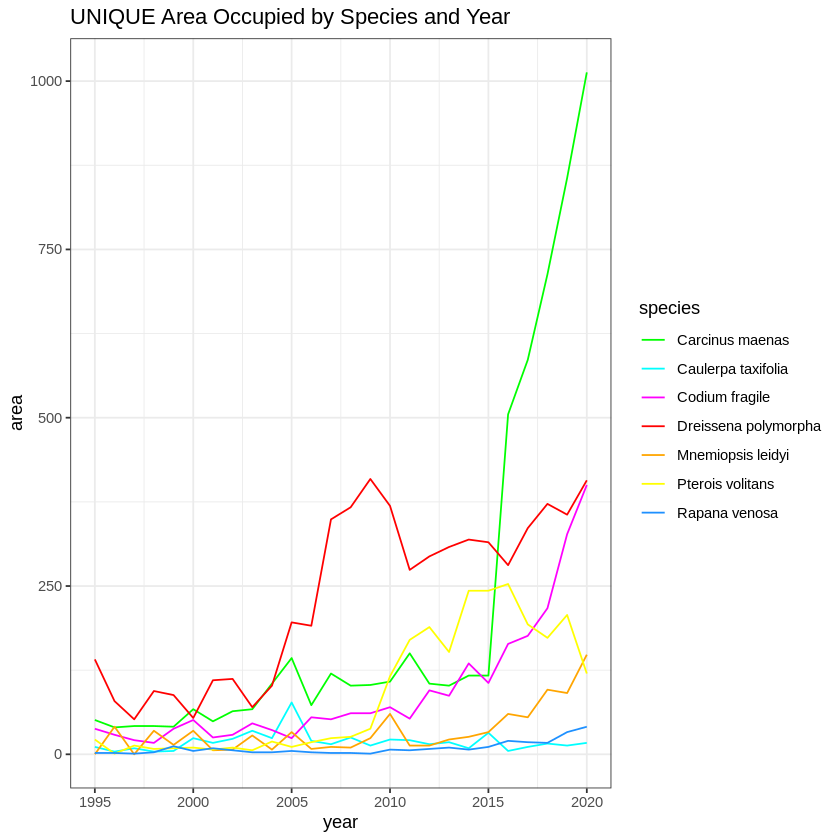

In [6]:
# area line plot ...

do.area.line<-function(my.species='',my.prov='UNIQUE',
        my.sYear=min(df.exp$year),my.eYear=max(df.exp$year)){


my.species=species.style%>%.[,'Names']%>%grep(my.species,.)%>%species.style[.,'Names']    
my.prov=prov.style%>%.[,'prov']%>%grep(my.prov,.)%>%prov.style[.,'prov']    

df.exp<-df.exp[df.exp$species%in%my.species & df.exp$prov==my.prov,]
species.style<-species.style[species.style$Names%in%unique(df.exp$species),]
    
# prepare area data
df=df.exp%>%count(species,prov,year,area)%>%.[,1:4]%>%count(species,prov,year)

df=data.frame(data=c(rep(paste(df$year,df$species,sep=';'),df$n)))
df.area=data.frame(species=substr(df$data,6,str_length(df$data)),year=as.integer(substr(df$data,1,4)))

suppressWarnings(print(
ggplot() + 
geom_freqpoly(data=df.area,aes(x=year,color=species),binwidth=my.binwidth)+
scale_color_manual(name = 'species', values=species.style$sColors, labels=species.style$Names)+
labs(title=paste(my.prov,'Area Occupied by Species and Year'))+ylab('area')+
theme_bw()+xlim(my.sYear,my.eYear)
))
}

my.binwidth<-1
do.area.line('',,1995,2020)

`geom_smooth()` using formula 'y ~ x'


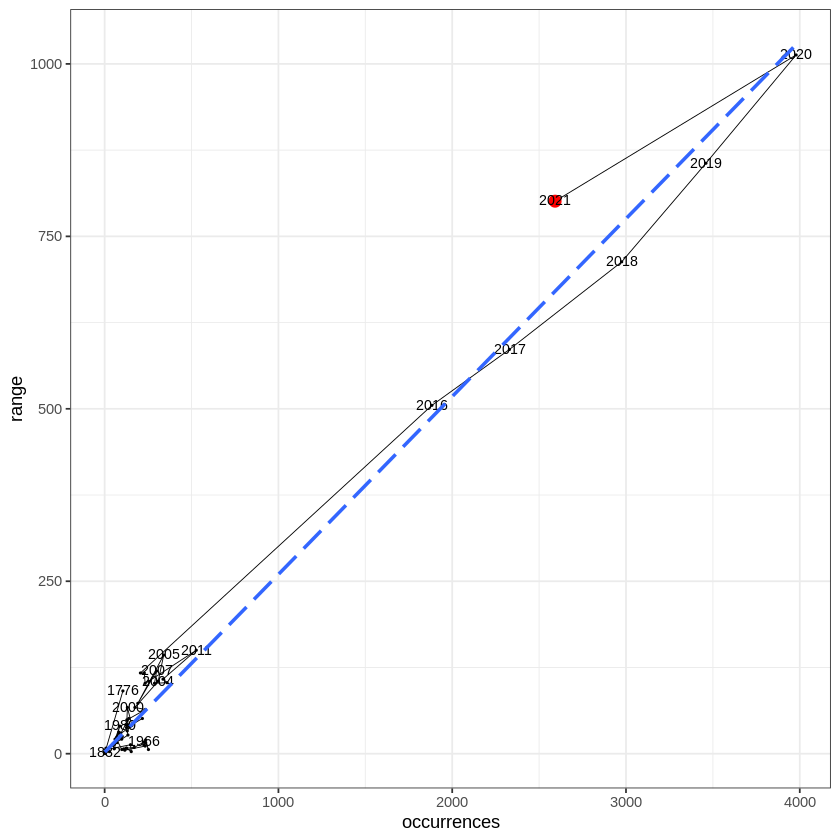

In [7]:
# graph OCCS AREA and YEAR

do.compare<-function(my.species='',my.prov='UNIQUE',
        my.sYear=min(df.exp$year),my.eYear=max(df.exp$year),my.binwidth=5,
        my.zoom=FALSE){

my.species=species.style%>%.[,'Names']%>%grep(my.species,.)%>%species.style[.,'Names']    
my.prov=prov.style%>%.[,'prov']%>%grep(my.prov,.)%>%prov.style[.,'prov']    
        
df.exp<-df.exp[df.exp$prov==my.prov&df.exp$species==my.species,]
x=df.exp%>%count(year)
    
# prepare area data
df.area=df.exp%>%count(species,prov,year,area)%>%.[,1:4]%>%count(species,prov,year)
df.area=data.frame(data=c(rep(paste(df.area$year,df.area$species,sep=';'),df.area$n)))
df.area=data.frame(species=substr(df.area$data,6,str_length(df.area$data)),year=as.integer(substr(df.area$data,1,4)))
y=df.area%>%count(year)
    
xy=merge(x,y,by='year')
names(xy)=c('year','occs','areas')

ggplot(xy, aes(x=occs, y=areas)) + 
    geom_path(size=.25)+
    geom_point(size=.25)+
    geom_point(data=xy[xy$year==my.eYear,],aes(x=occs,y=areas),color='red',size=3)+
    geom_text(label=xy$year,size=3,nudge_x = 1,nudge_y = 1,check_overlap = T)+
    geom_smooth(method = 'lm', se = FALSE,linetype = "longdash")+
    xlab('occurrences')+
    ylab('range')+
    theme_bw()
}

do.compare('Car','UNIQUE')

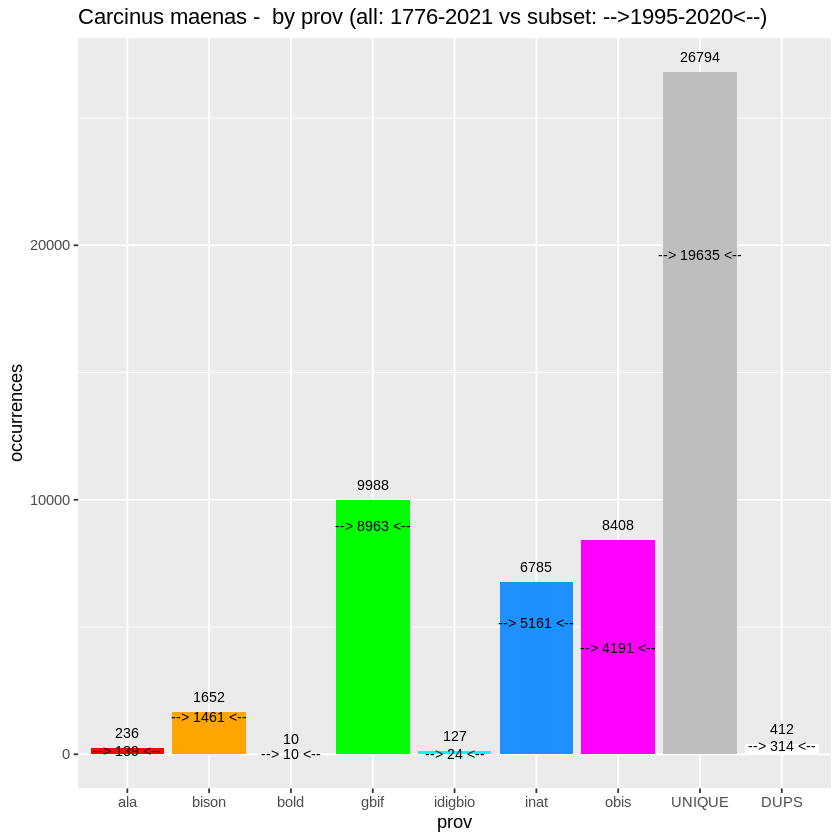

In [8]:
# prov bar plot

do.bar<-function(my.species='',
        my.sYear=min(df.exp$year),my.eYear=max(df.exp$year)){

my.species=species.style%>%.[,'Names']%>%grep(my.species,.)%>%species.style[.,'Names']    
    
# all years
df.exp<-df.exp[df.exp$species==my.species,]
df1.min.yr<-min(df.exp$year); df1.max.yr<-max(df.exp$year)    
df1=merge(x=prov.style[,c(1,3,4)],y=df.exp%>%count(prov),by='prov')
    
    
p<-ggplot() + 
    geom_bar(data=df1,aes(x=reorder(prov,order), y=n, fill=prov),stat= "identity",position=position_dodge())+
    scale_fill_manual(name = "prov", values = df1$color, labels = df1$prov)+
    geom_text(data=df1,aes(x=reorder(prov,order),y=n, label=n), position=position_dodge(width=0.9),vjust=-1.0, size=3)

# subset of years
df.exp=df.exp[df.exp$year>=my.sYear & df.exp$year<=my.eYear,]
df2.min.yr<-min(df.exp$year); df2.max.yr<-max(df.exp$year)    
df2=merge(x=prov.style[,c(1,3,4)],y=df.exp%>%count(prov),by='prov')

subset<-FALSE
if((sum(df1$n,na.rm=TRUE))!=(sum(df2$n,na.rm=TRUE))){
    subset<-TRUE
    p<-p+geom_text(data=df2,aes(x=reorder(prov,order), y=n, label=paste('--> ',n,' <--',sep='')),size=3)
}

p+labs(title=paste(my.species,' - ',' by prov (all: ',df1.min.yr,'-',df1.max.yr,
                ifelse(subset,paste(' vs subset: -->',df2.min.yr,'-',df2.max.yr,'<--',sep=''),''),')',sep=''))+
    theme(legend.position = "none")+xlab('prov')+ylab('occurrences')
}

do.bar('Car',1995,2020)

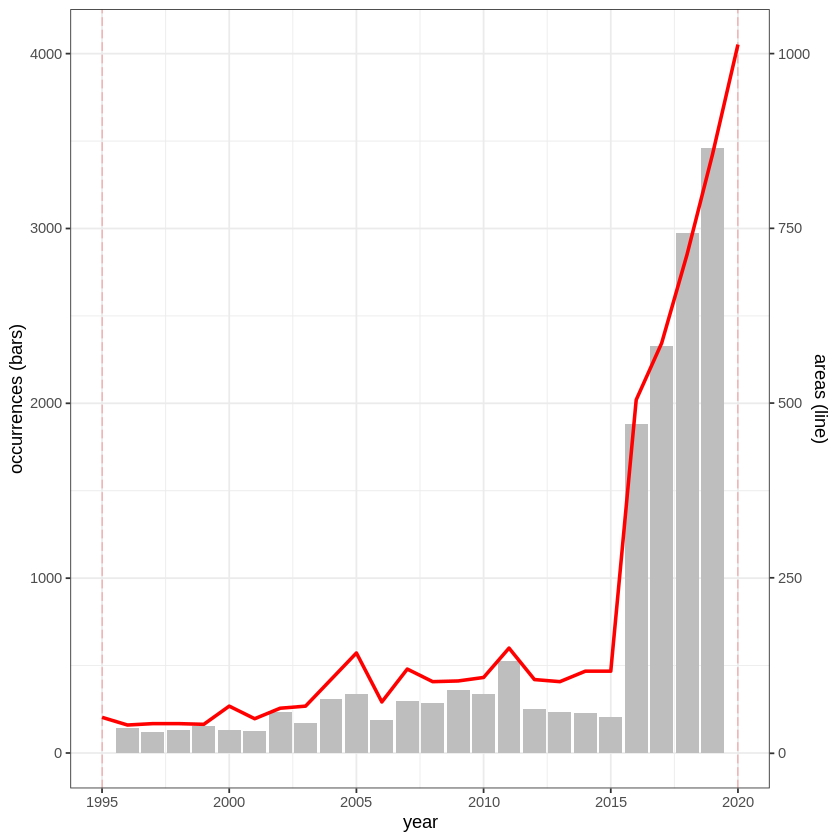

In [9]:
# plot occurrences and areas over time by species                

do.timeline<-function(my.species='',my.prov='UNIQUE',
        my.sYear=min(df.exp$year),my.eYear=max(df.exp$year),my.binwidth=5,
        my.zoom=TRUE){

my.species=species.style%>%.[,'Names']%>%grep(my.species,.)%>%species.style[.,'Names']    
my.prov=prov.style%>%.[,'prov']%>%grep(my.prov,.)%>%prov.style[.,'prov']    
        
df.exp<-df.exp[df.exp$prov==my.prov&df.exp$species==my.species,]
y1=df.exp%>%count(year)
    
# prepare area data
df.area=df.exp%>%count(species,prov,year,area)%>%.[,1:4]%>%count(species,prov,year)
df.area=data.frame(data=c(rep(paste(df.area$year,df.area$species,sep=';'),df.area$n)))
df.area=data.frame(species=substr(df.area$data,6,str_length(df.area$data)),year=as.integer(substr(df.area$data,1,4)))
y2=df.area%>%count(year)

conv=round(max(y1$n)/max(y2$n))
    
p<-ggplot() + 
    geom_bar(data=y1, aes(x = year, y = n), stat = "identity", fill = "grey") +
    geom_line(data=y2, aes(x = year, y = n*conv), size = 1, color = "red") + 
    geom_vline(xintercept = my.sYear, colour='red',linetype = "longdash",size=.1) +
    geom_vline(xintercept = my.eYear, colour='red',linetype = "longdash",size=.1) +
    scale_y_continuous(name = "occurrences (bars)", 
    sec.axis = sec_axis(~./conv, name = "areas (line)"))+
    theme_bw()

if(my.zoom){ 
    p<-p+xlim(my.sYear,my.eYear)
}
suppressWarnings(print(p))
}

do.timeline('Car','UNIQUE',1995,2020,my.binwidth=1)

In [10]:
# map by species with option for pacific centric view ... 

do.map<-function(my.prov='*UNIQUE',my.spec='^P',my.sYear=0,my.eYear=9999,my.eez='any',
            my.fao='any',my.eezlabel=0,my.faolabel=0,
            my.zoom=FALSE,my.pacific=FALSE){

if(my.pacific){
    world <- map_data('world', wrap=c(-25,335), ylim=c(-55,75))    
    df.prov$longitude <- ifelse(df.prov$longitude < -25, df.prov$longitude + 360, df.prov$longitude)
    fao.shp<-fao.shp.pac
}

my.spec<-species.style$Name[grep(my.spec,species.style$Name)]
pNames<-unique(df.prov$prov)
my.prov<-pNames[grep(my.prov,pNames)]

df.p<-df.prov[df.prov$species %in% my.spec,] # full range of species
df.s<-df.p[df.p$prov==my.prov & 
           df.p$year>=my.sYear & 
           df.p$year<=my.eYear
           ,] # year and prov subset

    if(my.fao[1]!='any' & my.eez[1]=='any'){
            df.s<-df.s[df.s$fao %in% my.fao,]
    }else{
        if(my.eez[1]!='any' & my.fao[1]=='any'){
        df.s<-df.s[df.s$eez %in% my.eez,]
    }else{
        if(my.eez[1]!='any' & my.fao[1]!='any'){
         df.s<-df.s[df.s$eez %in% my.eez | df.s$fao %in% my.fao,]    
    }}}

    
xlim = c(-180, 180)
ylim = c(-90, 90)

if(my.zoom){
    ylim <- c(min(df.s$latitude-1), max(df.s$latitude)+1)
    if(my.pacific){
        xlim <- c(min(df.s$longitude+1), max(df.s$longitude)-1)
    }else{
        xlim <- c(min(df.s$longitude-1), max(df.s$longitude)+1)
    }
}    

df.n<-aggregate(OCCS~species,data=df.s, sum); names(df.n)<-c('species','n') # aggregate occ
df.n$area<-''
for (species in unique(df.s$species)){
    x<-df.s[df.s$species==species,]
    df.n[df.n$species==species,'area']<-length(unique(paste(round(x$lon,1),round(x$lat,1))))   
}
df.n<- merge(df.s,df.n,id='species')
df.n$label<- paste(min(df.n$prov),' ',df.n$species,' ',min(df.n$year),'-', max(df.n$year), 
                   '\n OCCS=',df.n$n,' ; areas=',df.n$area, sep='') # format ggplot label    

world <- map_data("world")

suppressWarnings(print( 

ggplot() + 
    geom_sf(data = fao.shp, size = .1, color = "black", fill='slategray1') +
    geom_sf(data = eez.shp, size = .1, color = "blue", fill=NA) +
    geom_polygon(data = world, aes(x=long, y = lat, group = group), size=.05, fill='beige', color=NA) + 
    coord_sf(xlim = xlim, ylim = ylim)+
    geom_point(data=df.p, aes(x = longitude, y = latitude), size = 1.5, color='lightgray')+
    geom_point(data=df.n, aes(x = longitude, y = latitude, color=OCCS), size = .75)+
    scale_colour_gradient(low = "red", high = "yellow", na.value = NA)+
    geom_polygon(data = world, aes(x=long, y = lat, group = group), size=.25, fill=NA, color="darkgray")+
    geom_sf_text(data = fao.shp, aes(label = zone), colour = "black", size=my.faolabel)+
    geom_sf_text(data = eez.shp, aes(label = ISO_TER1 ), colour = "black", size=my.eezlabel)+
    theme_bw(base_size = 9)+
#    theme(legend.position = "none")+
    facet_wrap(~ label,ncol=2)
))
    
}

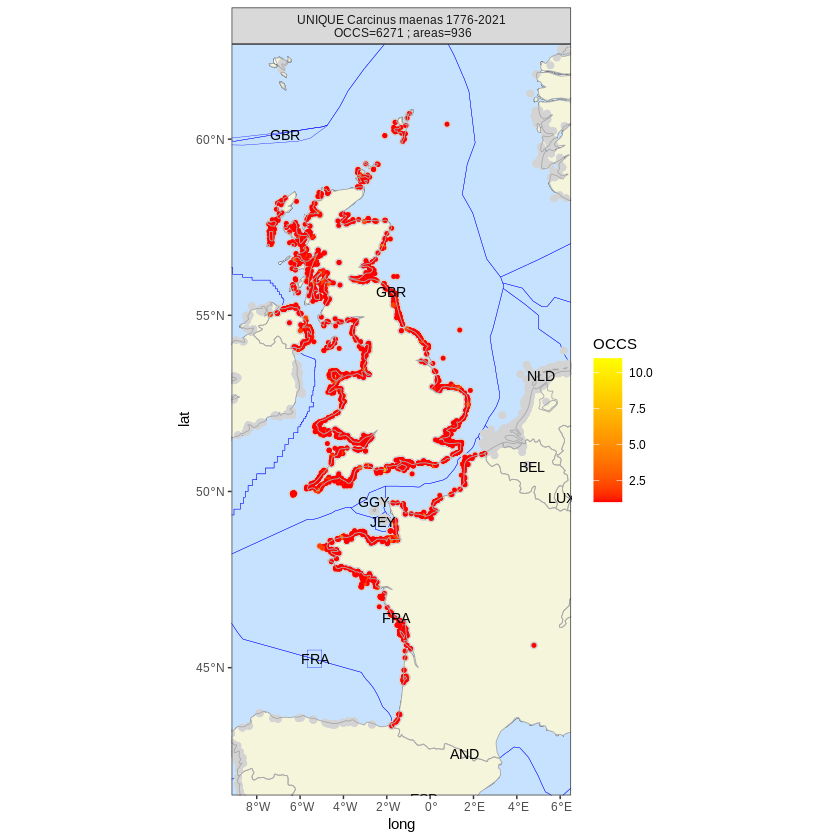

In [11]:
do.map('UNIQUE','Car',my.eez=c('GBR','FRA'),my.zoom=TRUE,my.eezlabel=3)

In [ ]:
do.map('UNIQUE','Cod',my.eez=c('GBR','FRA'),my.zoom=TRUE,my.eezlabel=3)

In [ ]:
do.map('UNIQUE','Codium',my.faolabel=2)

In [ ]:
do.map('DUPS','C',my.eez=c('GBR','DEU','NLD','FRA','IRL','NOR','ISL','ESP','PRT','ITA','GRC','TUR'),
       my.fao=c(27,37),my.zoom=TRUE,my.eezlabel=2)

In [ ]:
do.map('UNIQUE','Cod',my.eez=c('USA','CAN','MEX'),my.fao=c(02,31,21,67,77),my.zoom=TRUE,my.eezlabel=2)

In [ ]:
do.map('inat','P',my.faolabel=2)

In [ ]:
do.map('DUPS','P',my.faolabel=2)

In [ ]:
do.map('DUPS','Co',my.faolabel=2,my.fao=27,my.eez=c('GBR','FRA','DEU'),my.eezlabel=2,my.zoom=TRUE)